In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing.label import LabelBinarizer
from models import Classifier, Regression
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, CVOperator, df_cv_split
from utils import make_roc_plot

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


TODO:
* setup some way of fixing the folds over which cv is done
* combine features from multiple layers with keras models
* try the gifford ensembl model

## Breakpoints

Calculate the breakpoints inside each regulatory element.

In [3]:
breakpoint_df = get_breakpoint_df(df)
# Save breakpoints to CSV
breakpoint_df.to_csv('data/cagi5_bkpt.csv')
# Look at breakpoints
breakpoint_df[breakpoint_df['is_break']!='no'].head(15)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,start,NaN,True,0.0
47,X,138612684,G,T,-0.02,0.00,0,release_F9,0.048,-0.233,3.45,-2.0100,end,16.0,False,0.0
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,0.009,0.470,3.27,1.9200,start,NaN,True,1.0
95,X,138612716,G,T,-0.15,0.04,0,release_F9,0.055,0.581,3.32,0.4310,end,16.0,False,1.0
96,X,138612765,C,A,0.07,0.01,0,release_F9,0.420,-0.304,4.22,0.2990,start,NaN,True,2.0
143,X,138612780,T,G,0.18,0.02,0,release_F9,0.525,0.470,4.69,4.6900,end,16.0,False,2.0
144,X,138612877,G,A,-0.09,0.05,0,release_F9,0.864,0.581,5.08,5.0800,start,NaN,True,3.0
190,X,138612892,C,T,0.12,0.01,0,release_F9,0.508,0.581,5.08,1.7900,end,16.0,False,3.0
191,X,138612909,C,A,0.05,0.02,0,release_F9,0.453,0.581,5.08,0.0736,start,NaN,True,4.0
235,X,138612924,A,G,-0.01,0.00,0,release_F9,0.614,0.470,4.55,0.6710,end,16.0,False,4.0


## Cross-validation folds

Split the training data into folds respecting the breakpoints.

In [4]:
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[3], [0], [2], [4], [1]],
 'release_GP1BB': [[1, 5], [3], [4], [2], [0]],
 'release_HBB': [[1], [0], [2], [], []],
 'release_HBG1': [[3], [2], [1], [0], []],
 'release_HNF4A': [[0], [2], [3], [1], []],
 'release_IRF4': [[7, 1], [5, 2], [3, 6], [4], [0]],
 'release_IRF6': [[6, 2], [4, 8], [1, 5], [0, 3], [7]],
 'release_LDLR': [[1], [2], [0], [4], [3]],
 'release_MSMB': [[1, 2], [4, 8], [5, 7], [3, 6], [0]],
 'release_MYCrs6983267': [[7, 2], [1, 3], [8, 0], [5, 6], [4]],
 'release_PKLR': [[6, 4], [2, 5], [7, 1], [0], [3]],
 'release_SORT1': [[3, 0], [1, 4], [2, 6], [5, 8], [7]],
 'release_TERT-GBM': [[2], [3], [4], [1], [0]],
 'release_TERT-HEK293T': [[1], [2], [0], [4], [3]],
 'release_ZFAND3': [[0, 7, 9], [6, 1], [4, 8], [3, 10], [5, 2]]}

## Create features

In [5]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
enhancer1hot = EnhancerOneHot()
deepE1h = MultiFeatures([deepseadiffs, enhancer1hot])
snpcontext2 = SNPContext(context_size=2)
snpcontext4 = SNPContext(context_size=4)
conservation = Conservation()

## Logistic regression

Fit a logistic regression classifier to DeepSeaSNP features.

In [6]:
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Classifier,
                       model_kwargs={'features': deepseadiffs, 'model_name': 'lr'}),
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


[-1  0  1]
[0.62017722 0.54163231 0.61538784]


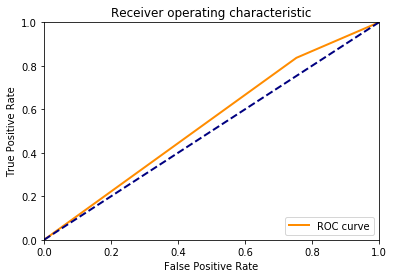

In [7]:
binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf_chunk['class'])
print(binarizer.classes_)
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [8]:
cvdf_chunk

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id,is_train,PredClass
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,start,NaN,True,0,True,-1.0
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.470,3.93,1.4900,no,NaN,False,0,True,-1.0
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.470,3.93,1.4900,no,NaN,False,0,True,-1.0
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.470,3.93,0.3370,no,NaN,False,0,True,-1.0
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.470,3.93,0.3370,no,NaN,False,0,True,-1.0
5,X,138612670,A,T,0.12,0.03,0,release_F9,0.008,0.470,3.93,0.3370,no,NaN,False,0,True,-1.0
6,X,138612671,T,A,0.06,0.02,0,release_F9,0.009,-0.404,3.93,-0.8070,no,NaN,False,0,True,1.0
7,X,138612671,T,C,0.26,0.21,1,release_F9,0.009,-0.404,3.93,-0.8070,no,NaN,False,0,True,-1.0
8,X,138612671,T,G,0.08,0.01,0,release_F9,0.009,-0.404,3.93,-0.8070,no,NaN,False,0,True,1.0
9,X,138612672,C,A,-0.13,0.05,0,release_F9,0.011,-0.251,3.93,0.6860,no,NaN,False,0,True,-1.0


## XGBoost

Cross-validate using XGBoost using a model fit to all regulatory regions but given the one-hot enhancer encodings.

In [9]:
# features = MultiFeatures([deepseadiffs, enhancer1hot, snpcontext4, conservation])
features = deepE1h
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Regression,
                       model_kwargs={'features': features, 'model_name': 'xgb'}),
                   fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
cv_regress.sample(6)

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id,is_train,PredConfidence,PredValue
617,11,5248363,C,A,-0.06,0.02,0,release_HBB,0.302,0.645,4.91,1.64,no,NaN,False,1,True,0.521481,-0.436750
3364,1,109817348,C,T,-0.02,0.01,0,release_SORT1,0.993,0.557,4.82,0.48,no,NaN,False,0,True,0.558268,0.019158
4271,6,37775423,T,G,-0.10,0.02,0,release_ZFAND3,0.676,0.435,4.61,3.42,no,NaN,False,2,False,0.364359,0.368052
530,11,5248270,C,A,-0.02,0.00,0,release_HBB,0.932,0.645,5.13,4.20,no,NaN,False,0,True,0.487708,-0.137693
3401,1,109817425,G,A,0.07,0.02,0,release_SORT1,0.161,0.557,4.80,4.80,no,NaN,False,1,True,0.438809,-0.408566
3938,5,1295340,C,A,0.06,0.00,0,release_TERT-GBM,0.007,0.263,1.59,-1.41,no,NaN,False,3,True,0.338797,-0.517203


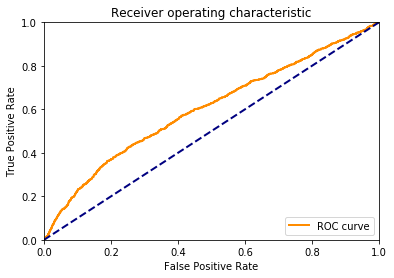

0.6021079554130402


In [10]:
cv_regress['Confidence'].abs() > 0.1
make_roc_plot(cv_regress, 'PredValue')
plt.show()
print(roc_auc_score(cv_regress['class'].abs(), cv_regress['PredValue'].abs()))

Cross-validate using models fit independently to each regulatory element

In [22]:
# features = MultiFeatures([deepseadiffs, enhancer1hot, snpcontext4, conservation])
import crossval, models, importlib
importlib.reload(crossval)
importlib.reload(models)
from crossval import ChunkCV, PerElementOperator, CVOperator, df_cv_split
from models import SubstitutionOneHot
subst = SubstitutionOneHot()
features = MultiFeatures([deepseadiffs, subst, snpcontext4, conservation])
# features = deepseadiffs
cv_chunk = ChunkCV(df,
                   operator=PerElementOperator(CVOperator(
                       Regression,
                       model_kwargs={'features': features, 'model_name': 'xgb'})),
                   fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
cv_regress.to_csv('data/regress.csv')
cv_regress.sample(6)

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id,is_train,PredConfidence,PredValue
2948,1,155271235,G,A,-0.10,0.01,0,release_PKLR,0.104,0.457,4.62,1.61,no,NaN,False,0,True,0.398655,-0.406425
1567,1,209989489,T,G,-0.29,0.07,0,release_IRF6,0.997,0.530,5.28,4.16,no,NaN,False,3,True,0.085722,0.254092
3702,1,109817654,A,C,0.70,0.33,1,release_SORT1,0.215,0.375,3.53,2.40,no,NaN,False,7,False,0.583043,0.277456
3306,1,155271642,C,G,0.00,0.00,0,release_PKLR,0.009,0.553,1.38,-0.90,no,NaN,False,7,True,0.135032,-0.366996
4062,5,1295266,G,T,-0.49,0.24,-1,release_TERT-HEK293T,0.001,-0.988,3.27,-6.55,no,NaN,False,2,True,0.185219,-0.224686
3826,5,1295158,G,T,1.66,1.00,1,release_TERT-GBM,0.003,0.298,2.82,2.82,no,NaN,False,1,True,0.168646,-0.020484


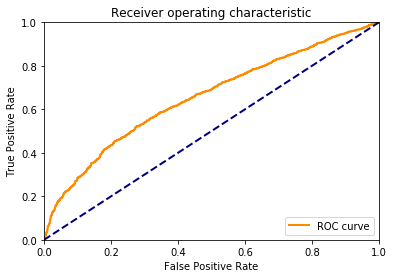

0.6546969002901206


In [23]:
cv_regress['Confidence'].abs() > 0.1
make_roc_plot(cv_regress, 'PredValue')
plt.show()
print(roc_auc_score(cv_regress['class'].abs(), cv_regress['PredValue'].abs()))

In [13]:
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Classifier,
                       model_kwargs={'features': deepseadiffs, 'model_name': 'xgb'}),
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()
cvdf_chunk.sample(6)

Getting predictions for fold 0


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Getting predictions for fold 1


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Getting predictions for fold 2


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Getting predictions for fold 3


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Getting predictions for fold 4


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id,is_train,PredClass
4483,6,37775606,A,G,0.01,0.00,0,release_ZFAND3,0.998,0.474,5.64,-1.26,no,NaN,False,6,True,0.0
66,X,138612707,C,A,0.09,0.04,0,release_F9,0.003,-0.214,2.91,2.04,no,NaN,False,1,False,0.0
3735,1,109817729,T,A,-0.08,0.04,0,release_SORT1,0.997,0.455,4.51,4.51,no,NaN,False,8,True,-1.0
1848,19,11199907,A,C,-0.10,0.01,0,release_LDLR,0.009,0.455,2.34,-4.69,no,NaN,False,0,True,0.0
1464,1,209989214,G,C,0.14,0.00,0,release_IRF6,0.031,-0.353,3.52,-5.17,no,NaN,False,0,True,0.0
1539,1,209989432,C,A,-0.02,0.00,0,release_IRF6,0.834,0.651,4.53,2.39,no,NaN,False,2,True,0.0


[0.67287649 0.66225378 0.64556122]


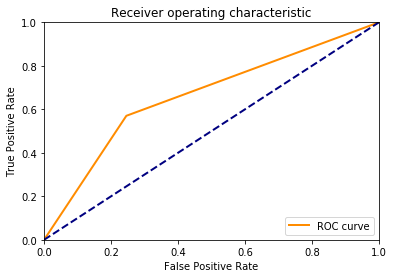

In [14]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

## Enhancer one-hot

One hot encode the identity of the enhancer.

In [15]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': enhancer1hot, 'model_name': 'lr'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

TypeError: __init__() got an unexpected keyword argument 'model_kwargs'

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepE1h, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext2, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext4, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': conservation, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
features = MultiFeatures([conservation, snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
features = MultiFeatures([conservation, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
features = MultiFeatures([snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
cvdf_chunk[['class', 'Value', 'Confidence']].as_matrix()